Using device: mps
Setup complete.
Loading training data from: ./data/train
Loading test data from: ./data/test

DataLoaders created successfully!
Number of training images: 10000
Number of testing images: 500
Fetching a fixed batch of real images from the test set...


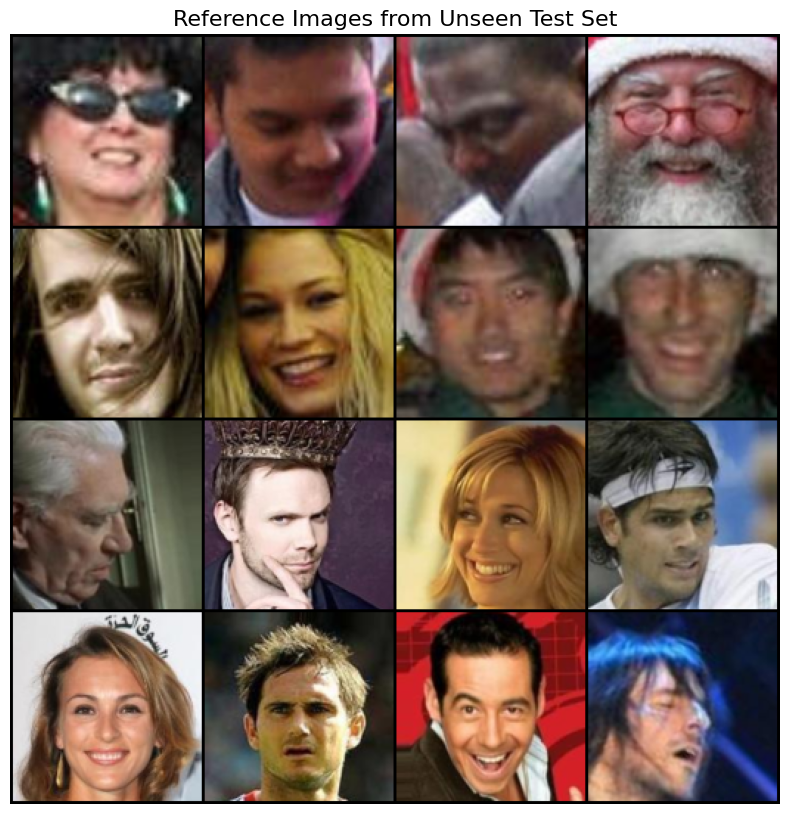

Generator and SelfAttention classes are defined.


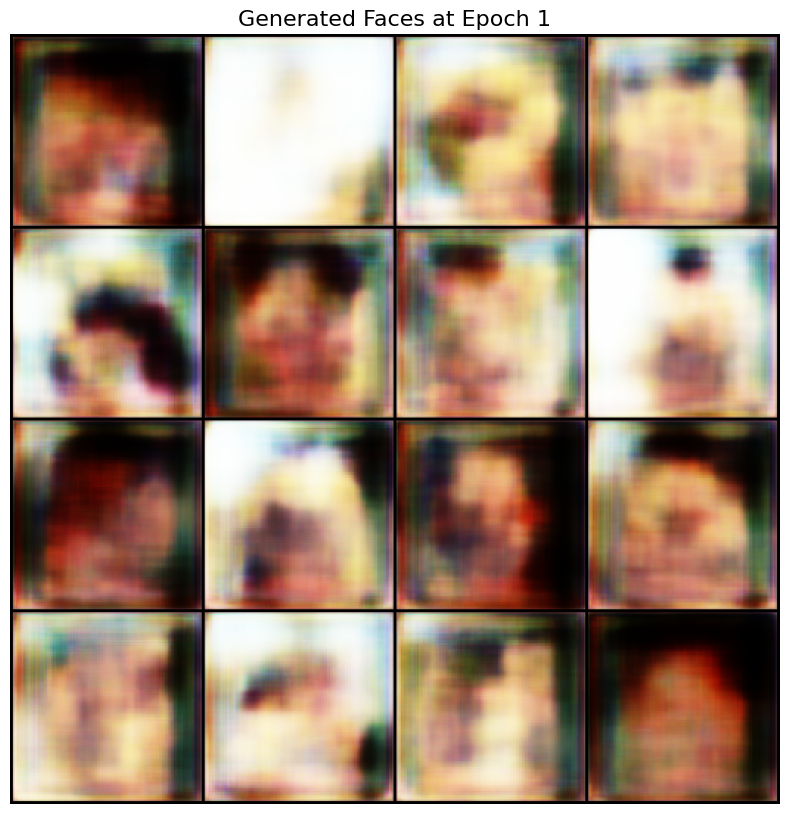

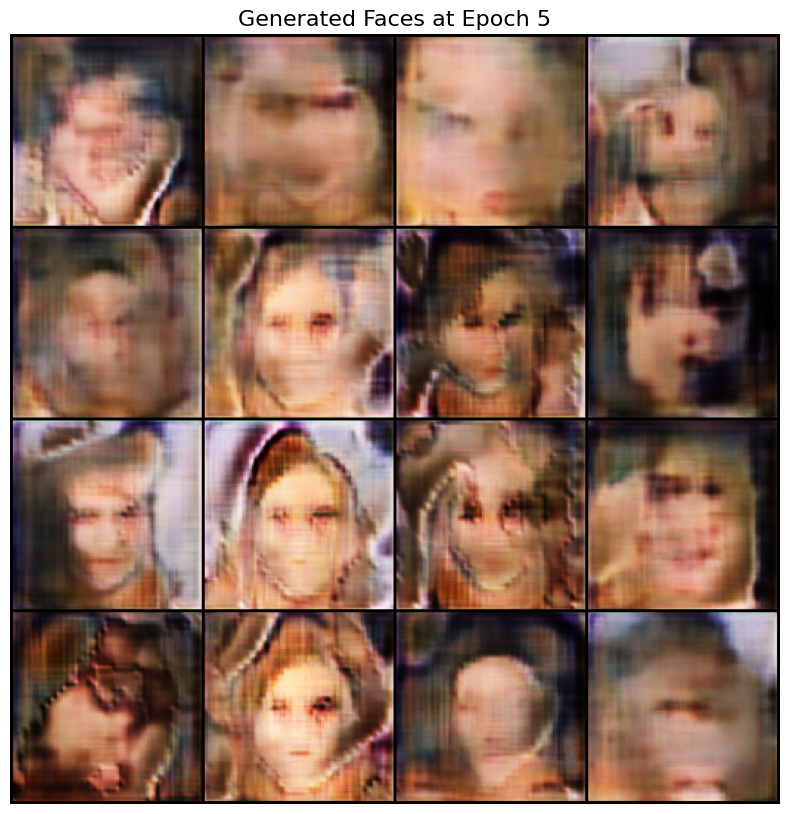

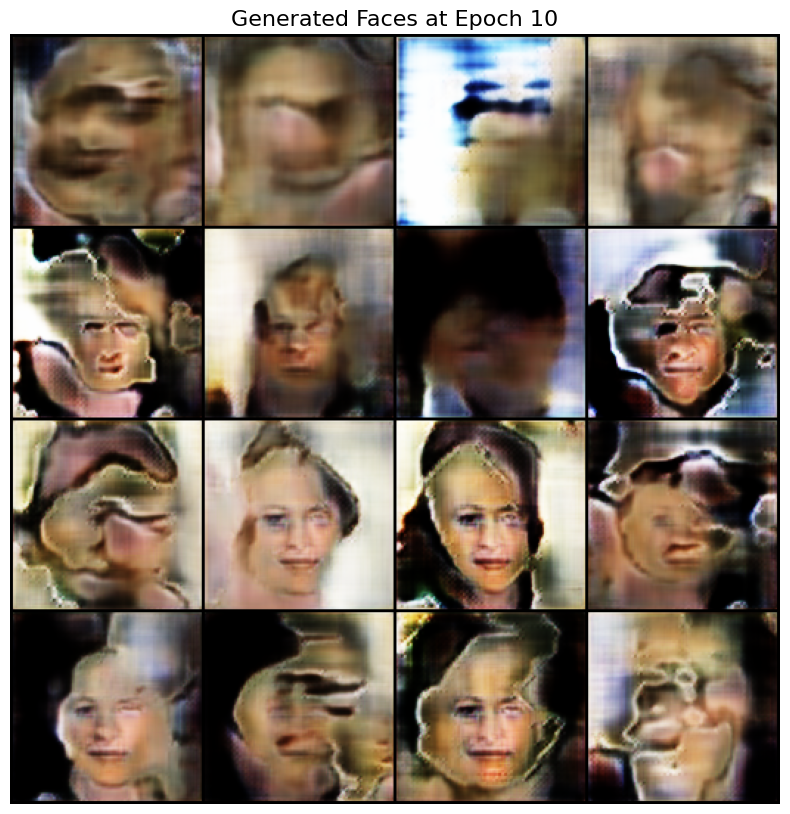

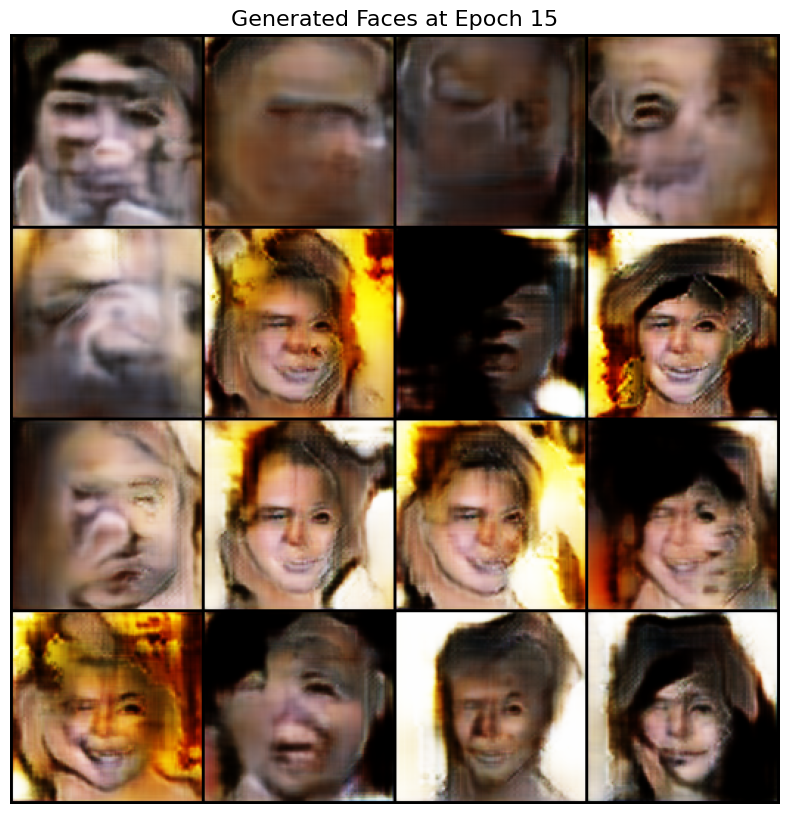

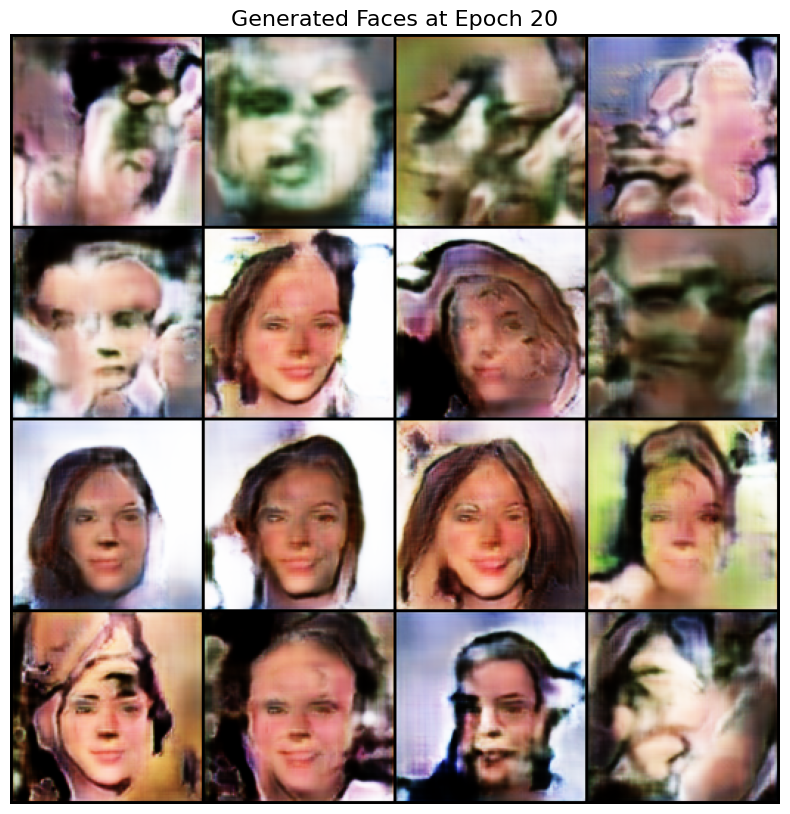

In [2]:
#
# CELL 1: Imports and Setup
#
# Description: This cell imports all necessary libraries, our custom modules,
# and sets up the configuration for the entire notebook.
#

import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

# Import our custom modules
from dataLoaders import get_dataloaders
from encoder import FaceNetEncoder
# We will define the Generator and SelfAttention classes in the next cell.

# --- Configuration ---
CHECKPOINT_DIR = "./checkpoints_widerface"
NUM_IMAGES_TO_SHOW = 16
IMAGE_SIZE = 128
NOISE_DIM = 100
EMBEDDING_DIM = 512

# --- Device Setup ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- Helper function for plotting ---
def show_images(images, title="Images", figsize=(10,10)):
    """Helper function to plot a grid of images."""
    images = images.to("cpu").detach() # Move images to CPU for plotting
    images = images * 0.5 + 0.5 # Denormalize from [-1, 1] to [0, 1]
    grid = make_grid(images, nrow=4, padding=2, normalize=False)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

print("Setup complete.")

#
# CELL 2: Load Fixed Test Data and Display
#
# Description: This cell loads the FaceNet encoder and the test dataloader.
# It fetches a single batch of 16 random test images. These images will be
# the unchanging source of identity for all subsequent generations.
# We also generate and store their embeddings once to use for all epochs.
#

# --- Load Encoder ---
encoder = FaceNetEncoder(device=device)
encoder.eval()

# --- Load Data ---
_, test_loader = get_dataloaders(data_root='.', batch_size=NUM_IMAGES_TO_SHOW)
if not test_loader:
    raise RuntimeError("Could not create test dataloader.")

# --- Get a fixed batch of real images and embeddings ---
print("Fetching a fixed batch of real images from the test set...")
fixed_real_images, _ = next(iter(test_loader))
fixed_real_images = fixed_real_images.to(device)

with torch.no_grad():
    fixed_embeddings = encoder(fixed_real_images)

# --- Display the real images that we will use as a reference ---
show_images(fixed_real_images, title="Reference Images from Unseen Test Set")

#
# CELL 3: Define Model Architecture
#
# Description: This cell contains the exact architecture of the Generator
# and the SelfAttention layer used during the final training run.
# This is crucial for PyTorch to be able to load the saved weights correctly.
#

class SelfAttention(nn.Module):
    """Self-Attention layer to help learn long-range dependencies."""
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class Generator(nn.Module):
    """Generator using Upsample + Conv2d and a Self-Attention layer."""
    def __init__(self, noise_dim=100, embedding_dim=512, channels=3):
        super(Generator, self).__init__()
        input_dim = noise_dim + embedding_dim
        self.init_block = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        def upsample_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )
        self.main = nn.Sequential(
            upsample_block(1024, 512),
            upsample_block(512, 256),
            upsample_block(256, 128),
            SelfAttention(128),
            upsample_block(128, 64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, embedding):
        combined_input = torch.cat([noise, embedding], dim=1)
        reshaped_input = combined_input.view(-1, combined_input.size(1), 1, 1)
        out = self.init_block(reshaped_input)
        out = self.main(out)
        return out

print("Generator and SelfAttention classes are defined.")

#
# CELL 4: Inference at Epoch 1
#
# Description: This is the template cell. It loads the generator weights
# from a specific epoch and generates images.
#
# You can copy this cell and change the `EPOCH_TO_LOAD` for other checkpoints.
#

# --- Configuration for this Cell ---
EPOCH_TO_LOAD = 1
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{EPOCH_TO_LOAD}.pth")

# --- Load the specific checkpoint ---
generator_epoch_1 = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)
try:
    generator_epoch_1.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator_epoch_1.eval()

    # --- Generate images ---
    with torch.no_grad():
        noise = torch.randn(NUM_IMAGES_TO_SHOW, NOISE_DIM, device=device)
        generated_images = generator_epoch_1(noise, fixed_embeddings)

    # --- Visualize ---
    show_images(generated_images, title=f"Generated Faces at Epoch {EPOCH_TO_LOAD}")

except FileNotFoundError:
    print(f"Checkpoint for epoch {EPOCH_TO_LOAD} not found.")


#
# CELL 5: Inference at Epoch 5
#
# Description: This is a copy of the cell above, but for epoch 5.
#

# --- Configuration for this Cell ---
EPOCH_TO_LOAD = 5
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{EPOCH_TO_LOAD}.pth")

# --- Load the specific checkpoint ---
generator_epoch_5 = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)
try:
    generator_epoch_5.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator_epoch_5.eval()

    # --- Generate images ---
    with torch.no_grad():
        noise = torch.randn(NUM_IMAGES_TO_SHOW, NOISE_DIM, device=device)
        generated_images = generator_epoch_5(noise, fixed_embeddings)

    # --- Visualize ---
    show_images(generated_images, title=f"Generated Faces at Epoch {EPOCH_TO_LOAD}")

except FileNotFoundError:
    print(f"Checkpoint for epoch {EPOCH_TO_LOAD} not found.")


#
# CELL 6: Inference at Epoch 10
#
# Description: Showing results from the halfway point.
#

# --- Configuration for this Cell ---
EPOCH_TO_LOAD = 10
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{EPOCH_TO_LOAD}.pth")

# --- Load the specific checkpoint ---
generator_epoch_10 = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)
try:
    generator_epoch_10.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator_epoch_10.eval()

    # --- Generate images ---
    with torch.no_grad():
        noise = torch.randn(NUM_IMAGES_TO_SHOW, NOISE_DIM, device=device)
        generated_images = generator_epoch_10(noise, fixed_embeddings)

    # --- Visualize ---
    show_images(generated_images, title=f"Generated Faces at Epoch {EPOCH_TO_LOAD}")

except FileNotFoundError:
    print(f"Checkpoint for epoch {EPOCH_TO_LOAD} not found.")


#
# CELL 7: Inference at Epoch 15
#
# Description: Showing results from later in the training.
#

# --- Configuration for this Cell ---
EPOCH_TO_LOAD = 15
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{EPOCH_TO_LOAD}.pth")

# --- Load the specific checkpoint ---
generator_epoch_15 = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)
try:
    generator_epoch_15.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator_epoch_15.eval()

    # --- Generate images ---
    with torch.no_grad():
        noise = torch.randn(NUM_IMAGES_TO_SHOW, NOISE_DIM, device=device)
        generated_images = generator_epoch_15(noise, fixed_embeddings)

    # --- Visualize ---
    show_images(generated_images, title=f"Generated Faces at Epoch {EPOCH_TO_LOAD}")

except FileNotFoundError:
    print(f"Checkpoint for epoch {EPOCH_TO_LOAD} not found.")


#
# CELL 8: Inference at FINAL Epoch 20
#
# Description: Showing the final results from the end of training.
#

# --- Configuration for this Cell ---
EPOCH_TO_LOAD = 20
GENERATOR_PATH = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{EPOCH_TO_LOAD}.pth")

# --- Load the specific checkpoint ---
generator_epoch_20 = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(device)
try:
    generator_epoch_20.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator_epoch_20.eval()

    # --- Generate images ---
    with torch.no_grad():
        noise = torch.randn(NUM_IMAGES_TO_SHOW, NOISE_DIM, device=device)
        generated_images = generator_epoch_20(noise, fixed_embeddings)

    # --- Visualize ---
    show_images(generated_images, title=f"Generated Faces at Epoch {EPOCH_TO_LOAD}")

except FileNotFoundError:
    print(f"Checkpoint for epoch {EPOCH_TO_LOAD} not found.")